In [0]:
#!pip install seaborn==0.9

In [0]:
#loading your keys from keys.json for twitter api
import json
key_file = 'keys.json'
with open(key_file) as f:
    keys = json.load(f)

In [0]:
#check for twitter authentication
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: jeffthestampede


In [0]:
#func to load twitter api keys from file I created
def load_keys(path):
    import json
    with open(path, "r") as f:
        return json.load(f)

In [0]:
#func that downloads the tweets of a specific user returns list of dictionary objects that each represent one tweet
def download_recent_tweets_by_user(user_account_name, keys):
    import tweepy
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    return [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name,tweet_mode='extended').items()]
   

In [0]:
#func that saves the tweets in a json file
def save_tweets(tweets, path):
    with open(path, "w")as f:
        import json
        json.dump(tweets,f)

In [0]:
#func load tweets that I have previously saved
def load_tweets(path):
    with open(path, "r")as f:
        import json
        tweets = json.load(f)
    return tweets

In [0]:
#func that checks if I have previously saved tweets in file system so not to overuse api
def get_tweets_with_cache(user_account_name, keys_path):
    from pathlib import Path
    save_path = user_account_name + "_recent_tweets.json"
    if not Path(save_path).is_file():
        keys_save = load_keys(keys_path)
        new_tweets = download_recent_tweets_by_user(user_account_name, keys_save)
        save_tweets(new_tweets, save_path)
    return load_tweets(save_path)

In [0]:
#collect Trump's recent tweets
trump_tweets = get_tweets_with_cache('realDonaldTrump', 'keys.json')

#check how many tweets got from api call for Trump
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3232


In [0]:
import pandas as pd

#take json data and create dataframe
trump = pd.DataFrame({"retweet_count": [num["retweet_count"] for num in trump_tweets],
                      "text":[z['text'] if "text" in z else z['full_text'] for z in trump_tweets],
                      "source":[y['source'] for y in trump_tweets],
                      "time": pd.to_datetime([x["created_at"] for x in trump_tweets])})
index = [index["id"] for index in trump_tweets]
trump["index"]=index
trump = trump.set_index("index").sort_index()
trump = trump[["retweet_count","source","text","time"]]
trump.head(5)

,retweet_count,source,text,time
index,,,,
997422764909912065,19738,"<a href=""http://twitter.com/download/iphone"" r...",“Apparently the DOJ put a Spy in the Trump Cam...,2018-05-18 10:24:53
997429518867591170,39875,"<a href=""http://twitter.com/download/iphone"" r...","Fake News Media had me calling Immigrants, or ...",2018-05-18 10:51:43
997471413266247681,22123,"<a href=""http://twitter.com/download/iphone"" r...",Why isn’t disgraced FBI official Andrew McCabe...,2018-05-18 13:38:11
997474432443707393,25180,"<a href=""http://twitter.com/download/iphone"" r...",Reports are there was indeed at least one FBI ...,2018-05-18 13:50:11
997493407097524224,16060,"<a href=""http://twitter.com/download/iphone"" r...",School shooting in Texas. Early reports not lo...,2018-05-18 15:05:35


In [0]:
#see how many different sources for tweets
trump['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'],
      dtype=object)

In [0]:
#remove html from source for cleaner look
trump['source'] = trump['source'].str.replace("<[^>]*>","")

Text(0, 0.5, 'Number of Tweets')

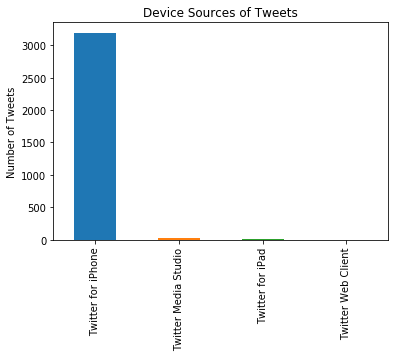

In [0]:
import matplotlib.pyplot as plt

trump['source'].value_counts().plot(kind="bar")
plt.title("Device Sources of Tweets")
plt.ylabel("Number of Tweets")

In [0]:
trump['source'].value_counts()

Twitter for iPhone      3194
Twitter Media Studio      30
Twitter for iPad           7
Twitter Web Client         1
Name: source, dtype: int64

In [0]:
#convert time to EST because that's where Trump mostly is
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,retweet_count,source,text,time,est_time
index,,,,,
997422764909912065,19738,Twitter for iPhone,“Apparently the DOJ put a Spy in the Trump Cam...,2018-05-18 10:24:53,2018-05-18 05:24:53-05:00
997429518867591170,39875,Twitter for iPhone,"Fake News Media had me calling Immigrants, or ...",2018-05-18 10:51:43,2018-05-18 05:51:43-05:00
997471413266247681,22123,Twitter for iPhone,Why isn’t disgraced FBI official Andrew McCabe...,2018-05-18 13:38:11,2018-05-18 08:38:11-05:00
997474432443707393,25180,Twitter for iPhone,Reports are there was indeed at least one FBI ...,2018-05-18 13:50:11,2018-05-18 08:50:11-05:00
997493407097524224,16060,Twitter for iPhone,School shooting in Texas. Early reports not lo...,2018-05-18 15:05:35,2018-05-18 10:05:35-05:00


In [0]:
#add column for hour of the day
hour = trump["est_time"].dt.hour
minute = trump["est_time"].dt.minute
second = trump["est_time"].dt.second
trump['hour'] = hour+minute/60+second/3600
trump.head()

,retweet_count,source,text,time,est_time,hour
index,,,,,,
997422764909912065,19738,Twitter for iPhone,“Apparently the DOJ put a Spy in the Trump Cam...,2018-05-18 10:24:53,2018-05-18 05:24:53-05:00,5.414722
997429518867591170,39875,Twitter for iPhone,"Fake News Media had me calling Immigrants, or ...",2018-05-18 10:51:43,2018-05-18 05:51:43-05:00,5.861944
997471413266247681,22123,Twitter for iPhone,Why isn’t disgraced FBI official Andrew McCabe...,2018-05-18 13:38:11,2018-05-18 08:38:11-05:00,8.636389
997474432443707393,25180,Twitter for iPhone,Reports are there was indeed at least one FBI ...,2018-05-18 13:50:11,2018-05-18 08:50:11-05:00,8.836389
997493407097524224,16060,Twitter for iPhone,School shooting in Texas. Early reports not lo...,2018-05-18 15:05:35,2018-05-18 10:05:35-05:00,10.093056


Text(0, 0.5, 'fraction')

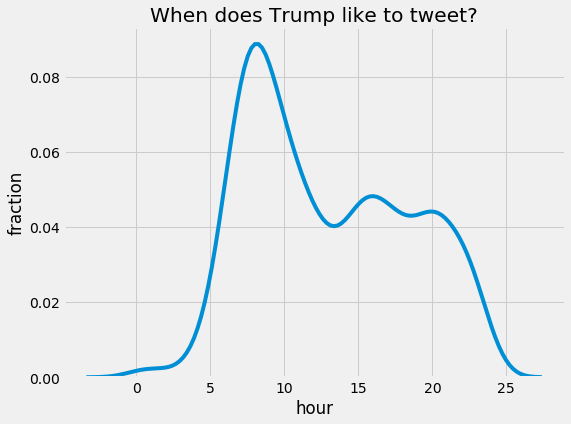

In [0]:
#plot distribution of when Trump likes to tweet
import seaborn as sns
plt.style.use('fivethirtyeight')

plt.figure(figsize=(8,6))
sns.distplot(trump['hour'], rug=False, hist=False)
plt.title("When does Trump like to tweet?")
plt.xlabel("hour")
plt.ylabel("fraction")

In [0]:
#I will use the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon to analyze the sentiment of Trump's tweets. 
#VADER is a lexicon and rule-based sentiment analysis tool that is specifically 
#attuned to sentiments expressed in social media which is great for our usage.
#The VADER lexicon gives the sentiment of individual words.

#df for vader_lexicon
vader = pd.read_csv('vader_lexicon.txt',usecols=[0,1],sep="\t",names=["token","polarity"],index_col="token")
#clean text for sentiment analysis
trump["text"]=trump["text"].str.lower()
punct_regex = r'[^\w\s]'
trump['no_punc'] = trump["text"].str.replace(punct_regex," ")

#tidy_format for sentiment
tidy_format = trump['no_punc'].str.split(expand=True).stack().reset_index(level=1)
tidy_format=tidy_format.rename(columns={'level_1': 'num', 0: 'word'})

In [0]:
#I can join the table with the lexicon table.
#Add a polarity column to the trump table. 
#The polarity column should contain the sum of the sentiment polarity of each word in the text of the tweet.

merge_table = tidy_format.merge(vader, how="left",left_on="word",right_index=True)
clean = merge_table.reset_index().groupby("index").sum().fillna(0)
trump['polarity'] = clean["polarity"]

In [0]:
#Most negative tweets
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   the trump portrait of an unsustainable border crisis is dead on. “in the last two years, ice officers made 266,000 arrests of aliens with criminal records, including those charged or convicted of 100,000 assaults, 30,000 sex crimes &amp; 4000 violent killings.” america’s southern....

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   ...this evil anti-semitic attack is an assault on humanity. it will take all of us working together to extract the poison of an

In [0]:
#Most positive tweets
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to a truly great football team, the clemson tigers, on an incredible win last night against a powerful alabama team. a big win also for the great state of south carolina. look forward to seeing the team, and their brilliant coach, for the second time at the w.h.

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new poll says trump, at over 90%, is the most popular republican in history of the party. wow!

   thank you, @wvgovernor jim justice, for that warm introduction. tonight, it was my great honor to attend the “greenbrier cla

Text(0, 0.5, 'density')

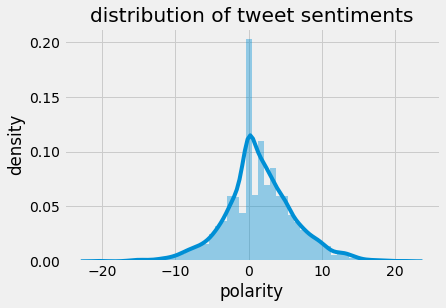

In [0]:
sns.distplot(trump['polarity'])
plt.title("distribution of tweet sentiments")
plt.ylabel("density")

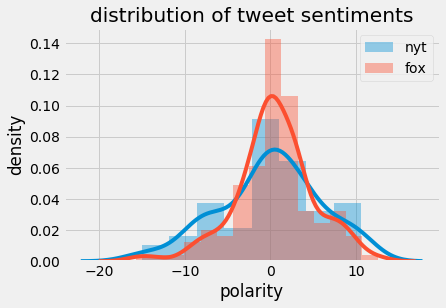

In [0]:
#Plot the distribution of tweet sentiments broken down by whether the text of the tweet contains nyt or fox.
nyt = trump[trump['text'].str.contains("nyt")]
fox = trump[trump['text'].str.contains("fox")]
sns.distplot(nyt['polarity'],label = 'nyt')
sns.distplot(fox['polarity'],label = 'fox')
plt.title("distribution of tweet sentiments")
plt.ylabel("density")
plt.legend()
#Both trends looks fairly like normal distribution
#but Trump seems have more positivity about fox 

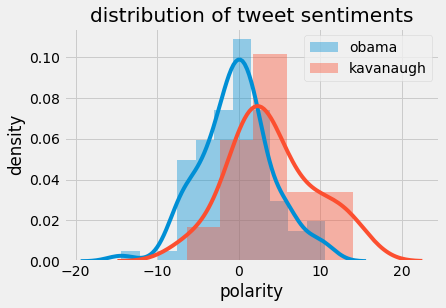

In [0]:
obama = trump[trump['text'].str.contains("obama")]
kavanaugh = trump[trump['text'].str.contains("kavanaugh")]
sns.distplot(obama['polarity'],label = 'obama')
sns.distplot(kavanaugh['polarity'],label = 'kavanaugh')
plt.title("distribution of tweet sentiments")
plt.ylabel("density")
plt.legend()

In [0]:
#The top 20 most retweeted words. Only words that appear in at least 25 tweets.
bigger25 = tidy_format.join(trump['retweet_count'])[["word","retweet_count"]].groupby("word").filter(lambda x: len(x) >= 25)
top_20 = bigger25.groupby("word").mean().sort_values("retweet_count",ascending=False).head(20)

In [0]:
top_20

,retweet_count
word,
fix,30004.920000
longer,29457.074074
mccabe,29307.148148
illegally,28549.933333
didn,28459.061538
votes,28130.529412
left,28077.130435
wall,27610.885870
judge,27546.666667


Text(0.5, 1.0, 'Top 20 Most Retweeted Words')

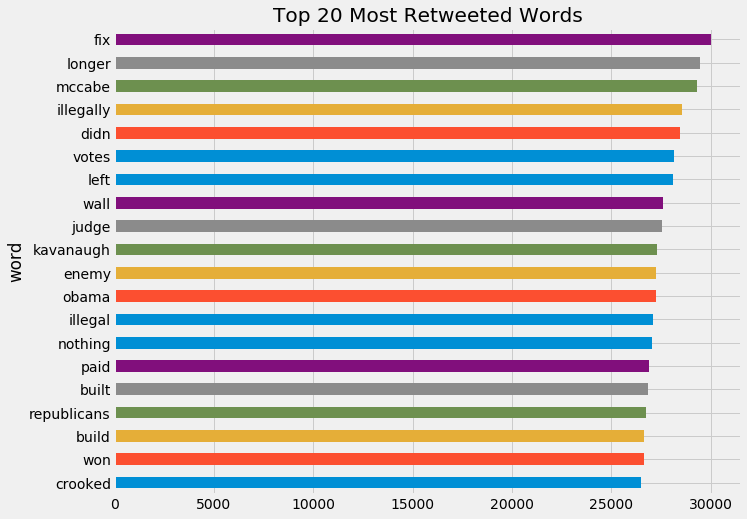

In [0]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));
plt.title("Top 20 Most Retweeted Words")

Text(0.5, 1.0, 'Tweet length and Polarity relationship')

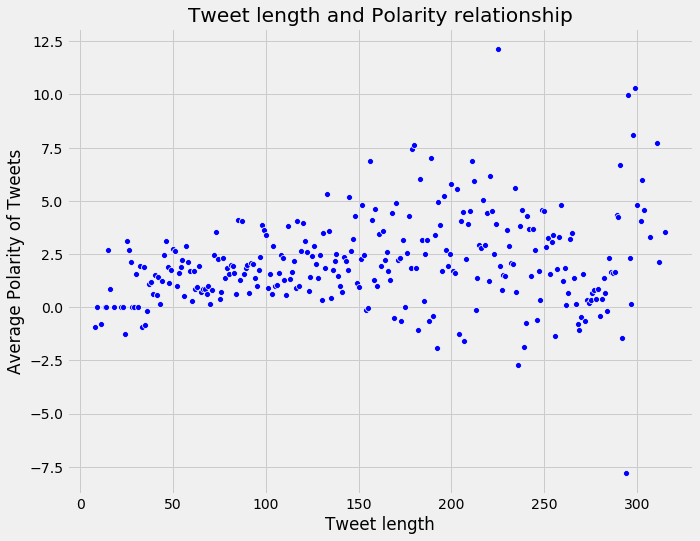

In [0]:
#How has the sentiment changed with length of the tweets?
#Tweet length column
trump['tweet_len'] = [len(x) for x in trump['no_punc']]
sentiment_len=trump[['polarity', 'tweet_len']]
#new df for sentiment and length
df = sentiment_len.groupby('tweet_len').mean().reset_index()
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df["tweet_len"],y=df["polarity"],color="blue")
plt.xlabel('Tweet length')
plt.ylabel('Average Polarity of Tweets')
plt.title("Tweet length and Polarity relationship")